In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [21]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Measles/cameroon.csv')
data.head()


,Year-Month,Cases
0,2011-1,58
1,2011-2,147
2,2011-3,186
3,2011-4,105
4,2011-5,114


In [22]:
data.shape

(159, 2)

In [23]:
data.columns

Index(['Year-Month', 'Cases'], dtype='object')

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year-Month  159 non-null    object
 1   Cases       159 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


In [25]:
data.describe()

,Cases
count,159.00
mean,136.60
std,218.59
min,4.00
25%,23.50
50%,65.00
75%,152.00
max,1634.00


In [26]:
data['Date'] = pd.to_datetime(data['Year-Month'])
data = data.drop(columns = 'Year-Month')
data = data.set_index('Date')
data = data.rename(columns = {'Cases':'Cases'})
data.head()

,Cases
Date,
2011-01-01,58
2011-02-01,147
2011-03-01,186
2011-04-01,105
2011-05-01,114


In [27]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [28]:
def tsplot(y, lags=24, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

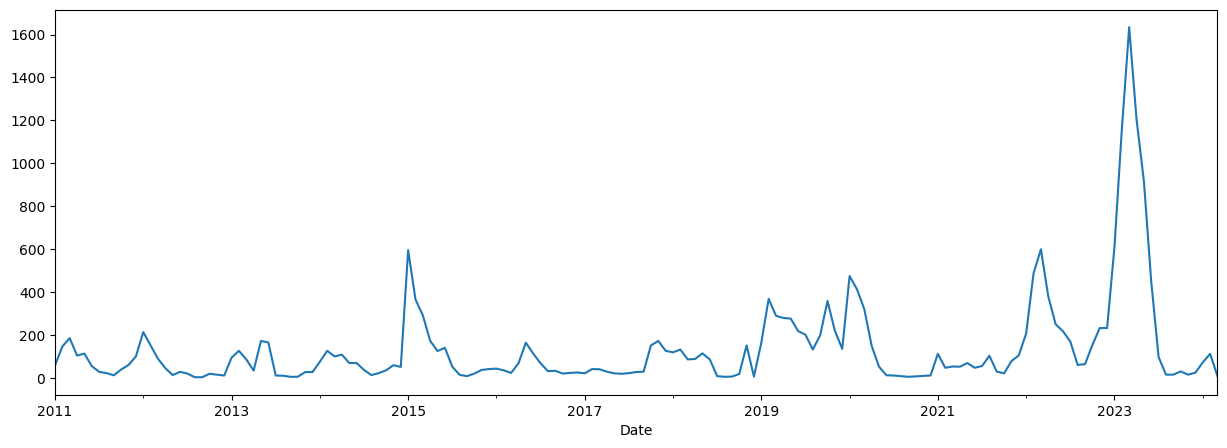

In [29]:
plt.figure(figsize = (15,5))
data['Cases'].plot();

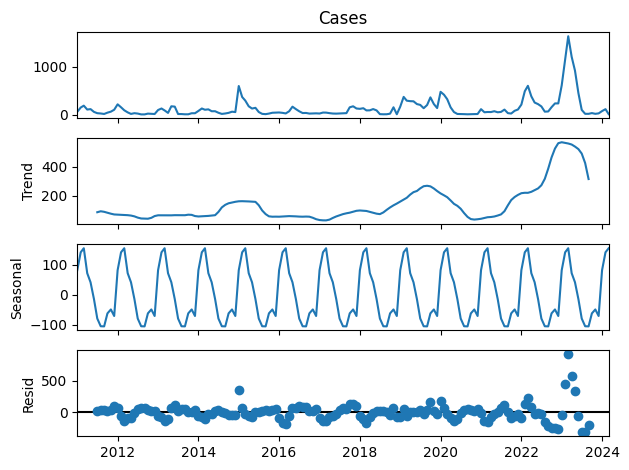

In [30]:
decomposition = sm.tsa.seasonal_decompose(data['Cases'],period = 12, model = 'additive').plot()
plt.show()

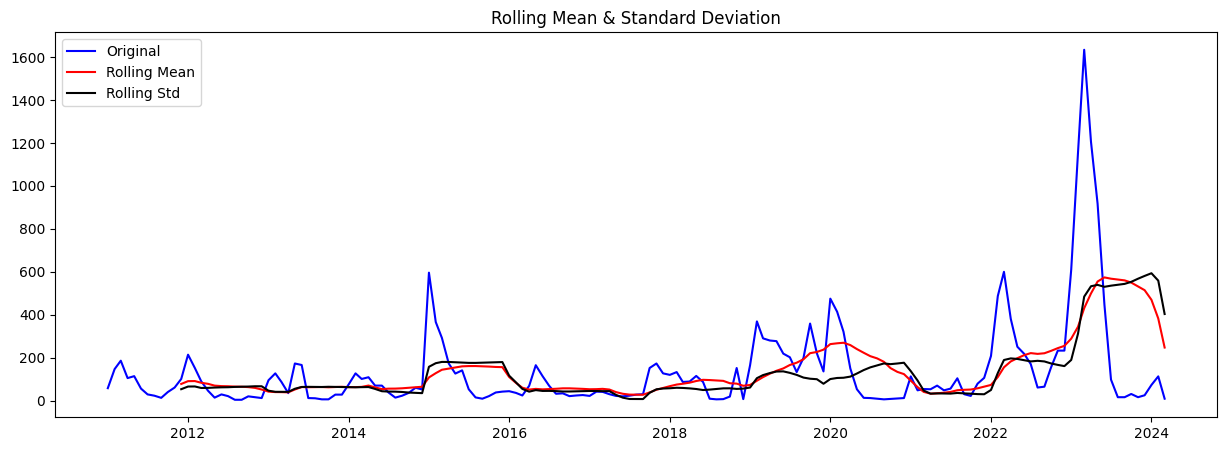

Results of Dickey-Fuller Test:
Test Statistic                 -5.25
p-value                         0.00
#Lags Used                      1.00
Number of Observations Used   157.00
Critical Value (1%)            -3.47
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [31]:
test_stationarity(data['Cases'])

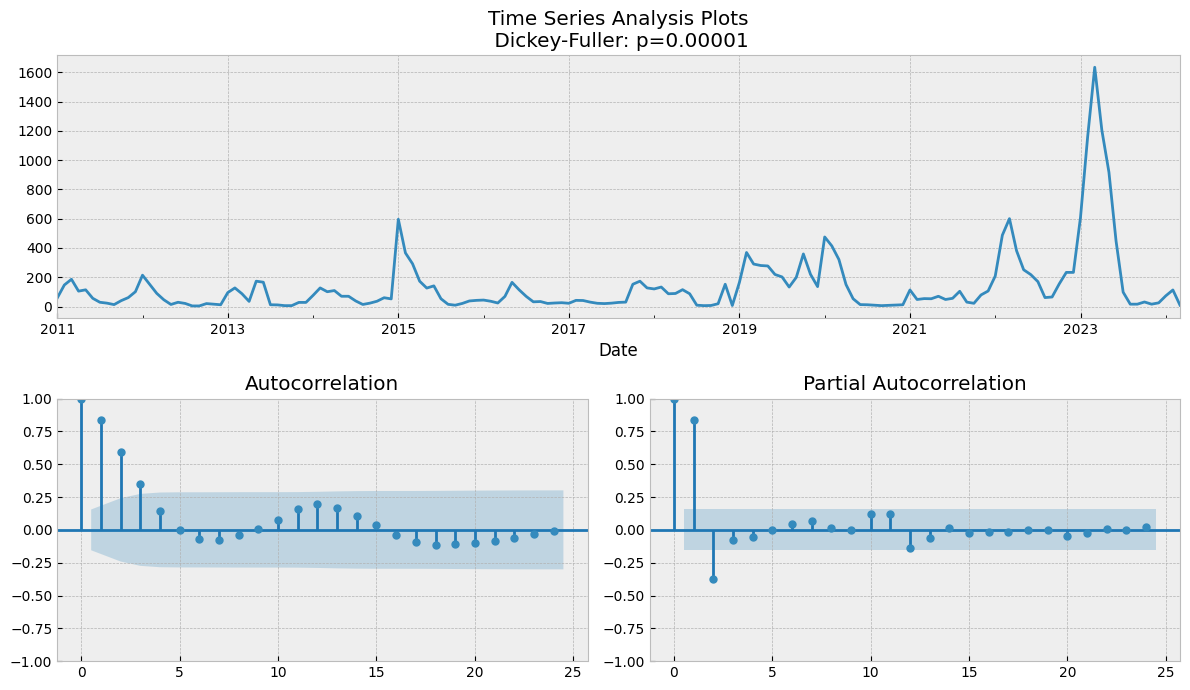

In [32]:
tsplot(data['Cases'])

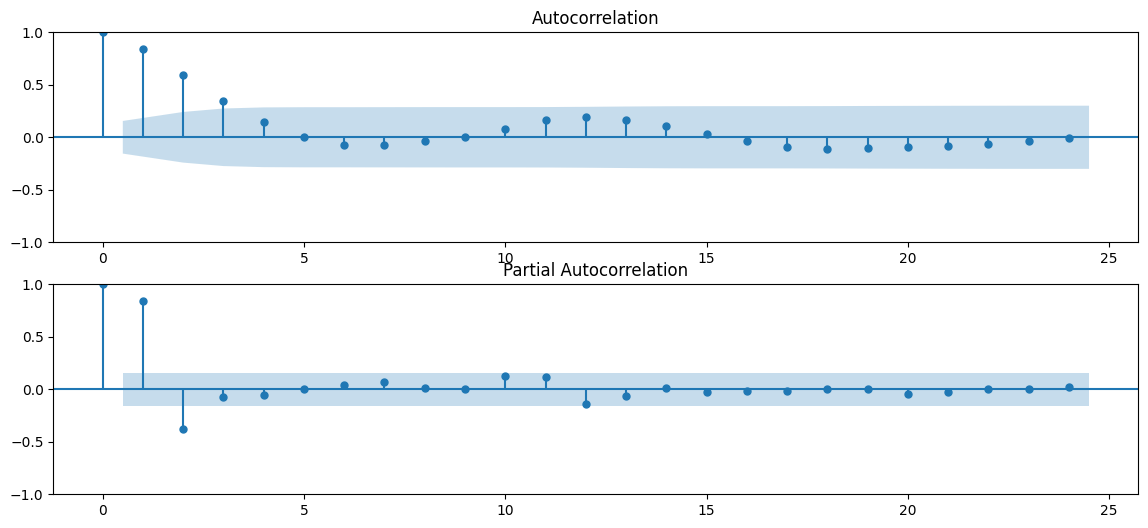

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(data, lags=24, ax=ax1)
ax2 = plot_pacf(data, lags=24, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

In [36]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.0 MB/s eta 0:00:00


In [38]:
train = data.iloc[0:147]
test = data.iloc[147:]

In [41]:
import pmdarima as pm
auto_model = pm.auto_arima(train["Cases"],
                          d=0, D=0, m=12, trend=None, seasonal=None,
                          start_p=0, start_q=0, max_order=15, test='adf',
                          stepwise=False, trace=True)

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2022.002, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1909.646, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1858.524, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1832.437, Time=0.32 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1827.523, Time=0.37 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1816.551, Time=0.66 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1807.424, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1798.813, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1800.685, Time=0.29 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1801.995, Time=0.42 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1802.850, Time=0.62 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=1803.694, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1798.571, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1800.557, Time=0.34 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1802.806, Time=0.54 sec
 ARIMA(2,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  147
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -896.286
Date:                Fri, 19 Jul 2024   AIC                           1798.571
Time:                        13:05:46   BIC                           1807.543
Sample:                    01-01-2011   HQIC                          1802.216
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2663      0.039     32.072      0.000       1.189       1.344
ar.L2         -0.2969      0.071     -4.186      0.000      -0.436      -0.158
sigma2      1.132e+04    639.637     17.698      0.000    1.01e+04    1.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               492.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             1.73
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

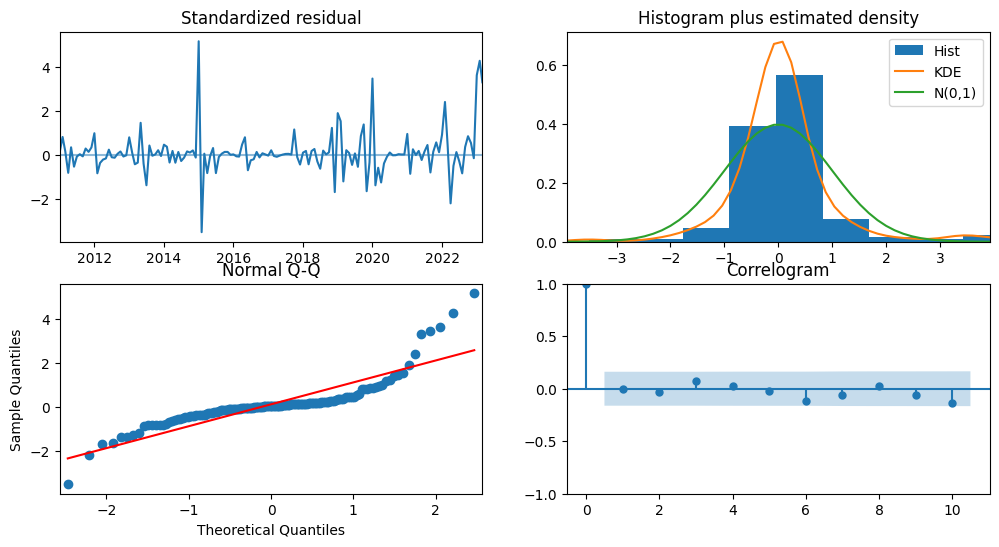

In [47]:
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12,6));

In [46]:
model = ARIMA(train["Cases"],order = (0,0,4))
model = model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Cases   No. Observations:                  147
Model:                 ARIMA(0, 0, 4)   Log Likelihood                -901.665
Date:                Fri, 19 Jul 2024   AIC                           1815.330
Time:                        13:05:44   BIC                           1833.273
Sample:                    01-01-2011   HQIC                          1822.620
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.1951     60.118      2.132      0.033      10.366     246.024
ma.L1          1.2167      0.044     27.601      0.000       1.130       1.303
ma.L2          0.9645      0.065     14.943      0.000       0.838       1.091
ma.L3          0.5598      0.156      3.579      0.000       0.253       0.866
ma.L4          0.1931      0.110      1.751      0.080      -0.023       0.409
sigma2      1.231e+04    844.373     14.584      0.000    1.07e+04     1.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               682.32
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                             2.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Cases   No. Observations:                  147
Model:                 ARIMA(0, 0, 4)   Log Likelihood                -901.665
Date:                Fri, 19 Jul 2024   AIC                           1815.330
Time:                        13:05:57   BIC                           1833.273
Sample:                    01-01-2011   HQIC                          1822.620
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.1951     60.118      2.132      0.033      10.366     246.024
ma.L1          1.2167      0.044     27.601      0.000       1.130       1.303
ma.L2          0.9645      0.065     14.943      0.000       0.838       1.091
ma.L3          0.5598      0.156      3.579      0.000       0.253       0.866
ma.L4          0.1931      0.110      1.751      0.080      -0.023       0.409
sigma2      1.231e+04    844.373     14.584      0.000    1.07e+04     1.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):               682.32
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               2.71   Skew:                             2.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

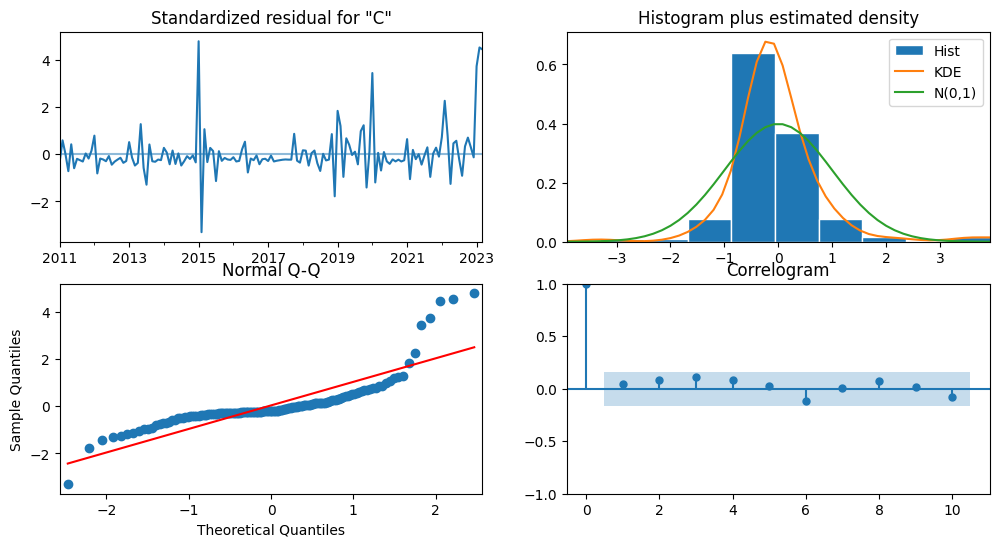

In [48]:
display(model.summary())
model.plot_diagnostics(figsize=(12,6));

In [55]:
from statsmodels.stats.diagnostic import acorr_ljungbox
lags = list(range(0, 13))
ljung_box_results = acorr_ljungbox(model.resid, lags=lags, return_df=True)
print(ljung_box_results)

    lb_stat  lb_pvalue
0     14.60        NaN
1      0.23       0.64
2      1.32       0.52
3      3.15       0.37
4      4.12       0.39
5      4.22       0.52
6      6.19       0.40
7      6.20       0.52
8      7.01       0.54
9      7.04       0.63
10     7.91       0.64
11    10.10       0.52
12    14.60       0.26


In [56]:
prd = model.forecast(steps=len(test))
prd

2023-04-01   1444.90
2023-05-01    967.04
2023-06-01    502.22
2023-07-01    223.68
2023-08-01    128.20
2023-09-01    128.20
2023-10-01    128.20
2023-11-01    128.20
2023-12-01    128.20
2024-01-01    128.20
2024-02-01    128.20
2024-03-01    128.20
Freq: MS, Name: predicted_mean, dtype: float64

In [61]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(test["Cases"],prd))
#print('Test RMSE: %.4f' % error)

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(test["Cases"], prd)


from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(test["Cases"],prd)
#print("Mean Squared Logarithmic Error (MSLE):", msle)

from sklearn.metrics import mean_absolute_percentage_error
#print('Mean Absolute Percentage Error (MAPE):',mean_absolute_percentage_error(pjme_test['Cases'],pjme_test['MW_Prediction']))

print('RMSE: %.2f' % error)
print(f"MAPE: {mape:.2f}%")
print('MAE:  %.2f' % mae)
print('MSLE: %.2f' % msle)

RMSE: 113.33
MAPE: 367.43%
MAE:  99.70
MSLE: 2.04


<ipython-input-65-31554eb642fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = prd


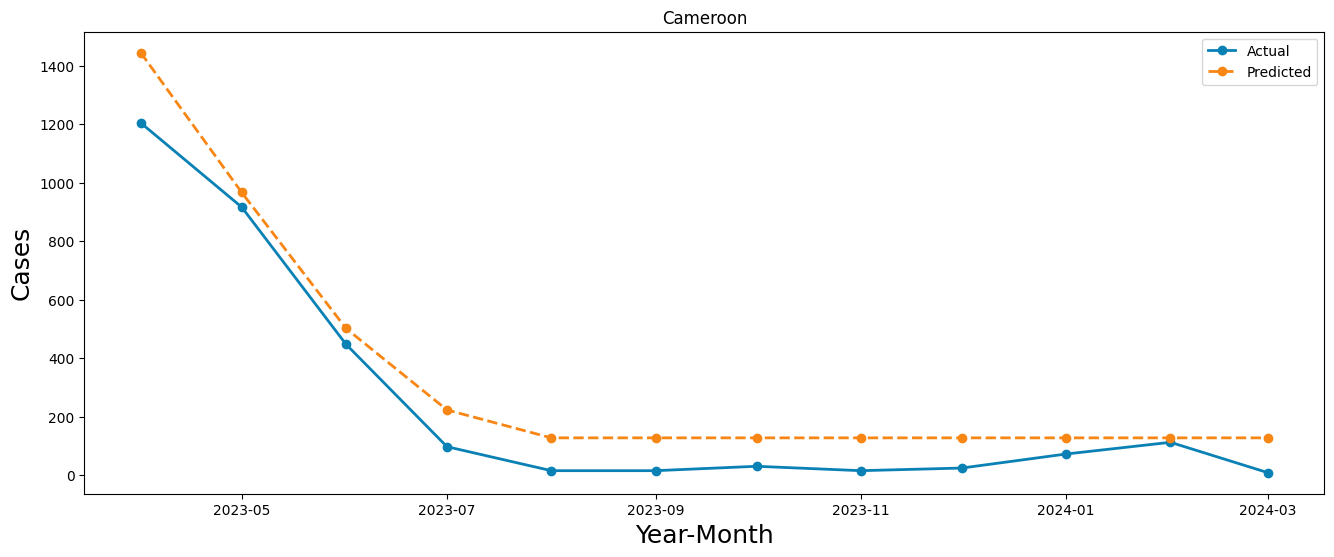

In [65]:
# Plot the data
valid = data[147:]
valid['Predictions'] = prd
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Cameroon')
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.plot(valid['Cases'], color='#0981b5', marker='o',linewidth=2)  # Actual cases
plt.plot(valid['Predictions'], color='#f78614',marker='o', linestyle='--',linewidth=2)  # Predicted cases (dashed line)
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()